In [ ]:
!pip install indic-transliteration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 7.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2-1587353678.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.107700
100,1.108500
150,1.083000
200,1.096300
250,1.058600
300,1.035500
350,1.063400
400,1.107000
450,1.101800
500,1.101900



✅ Validation Accuracy: 0.5957

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.69      0.62       890
           1       0.53      0.47      0.50      1128
           2       0.70      0.65      0.67       982

    accuracy                           0.60      3000
   macro avg       0.60      0.60      0.60      3000
weighted avg       0.60      0.60      0.59      3000


🧮 Confusion Matrix:
 [[615 236  39]
 [363 535 230]
 [100 245 637]]


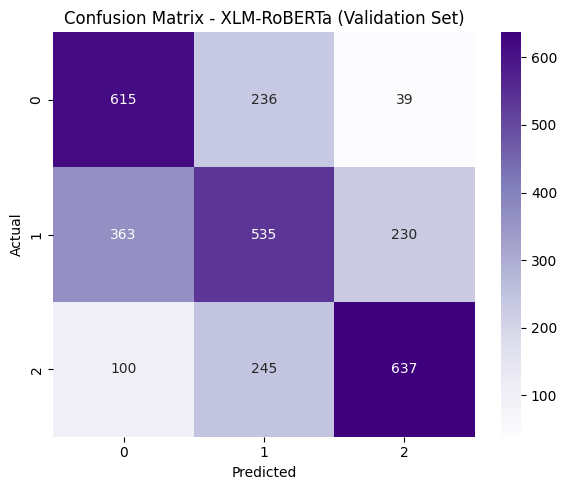

In [ ]:
import pandas as pd
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from indic_transliteration.sanscript import transliterate, DEVANAGARI, ITRANS
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Download NLTK tokenizer
nltk.download("punkt_tab")

# Load data
train_df = pd.read_csv("/content/drive/MyDrive/FinalTrainingOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
val_df = pd.read_csv("/content/drive/MyDrive/ValidationOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
test_df = pd.read_csv("/content/drive/MyDrive/FinalTest.tsv", sep="\t", names=["uid", "text"], header=None)

# Check for Devanagari script
def is_devanagari(word):
    return any('\u0900' <= ch <= '\u097F' for ch in word)

# Preprocessing function
def preprocess(text):
    text = str(text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002700-\U000027BF"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub('', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", " ", text)
    text = re.sub(r"[^\w\s\u0900-\u097F]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    processed = []
    for word in tokens:
        if is_devanagari(word):
            translit = transliterate(word, DEVANAGARI, ITRANS)
            processed.append(f"[hin] {translit}")
        elif word.isalpha():
            processed.append(f"[en] {word.lower()}")
        else:
            processed.append(f"[oth] {word}")
    return " ".join(processed)

# Apply preprocessing
train_df["text"] = train_df["text"].apply(preprocess)
val_df["text"] = val_df["text"].apply(preprocess)
test_df["text"] = test_df["text"].apply(preprocess)

# Encode labels
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
val_df["label"] = le.transform(val_df["label"])

# Tokenizer and Dataset
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

class HinglishDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Prepare datasets
train_dataset = HinglishDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = HinglishDataset(val_df["text"].tolist(), val_df["label"].tolist())

# Load model
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# Training arguments
training_args = TrainingArguments(
    output_dir="./xlmr_results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_steps=50,
    save_steps=500,
    save_total_limit=1,
    load_best_model_at_end=False,
    report_to=[],
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Train model
trainer.train()

# Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

val_loader = DataLoader(val_dataset, batch_size=32)
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=[str(c) for c in le.classes_])
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print results
print(f"\n✅ Validation Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", report)
print("\n🧮 Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples",
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XLM-RoBERTa (Validation Set)")
plt.tight_layout()
plt.show()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-1799680442.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.142200
100,1.128500
150,1.147300
200,1.105900
250,1.133400
300,1.119100
350,1.123900
400,1.113300
450,1.111000
500,1.116700


Step,Training Loss
50,1.142200
100,1.128500
150,1.147300
200,1.105900
250,1.133400
300,1.119100
350,1.123900
400,1.113300
450,1.111000
500,1.116700


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



✅ Validation Accuracy: 0.3760

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       890
           1       0.38      1.00      0.55      1128
           2       0.00      0.00      0.00       982

    accuracy                           0.38      3000
   macro avg       0.13      0.33      0.18      3000
weighted avg       0.14      0.38      0.21      3000


🧮 Confusion Matrix:
 [[   0  890    0]
 [   0 1128    0]
 [   0  982    0]]


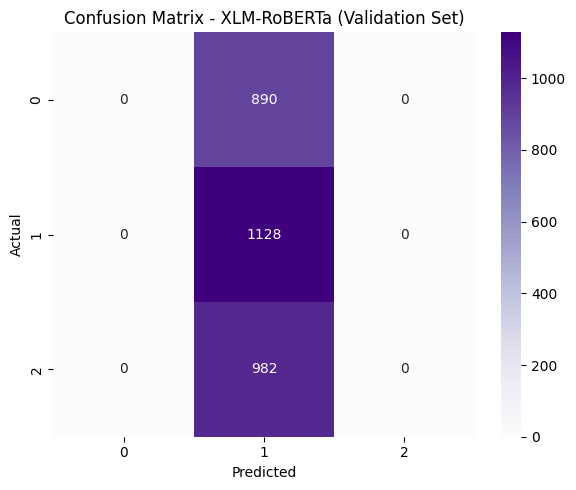

In [ ]:
import pandas as pd
import re
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from indic_transliteration.sanscript import transliterate, DEVANAGARI, ITRANS
from nltk.tokenize import word_tokenize
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Download NLTK tokenizer
nltk.download("punkt_tab")

# Load data
train_df = pd.read_csv("/content/drive/MyDrive/FinalTrainingOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
val_df = pd.read_csv("/content/drive/MyDrive/ValidationOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
test_df = pd.read_csv("/content/drive/MyDrive/FinalTest.tsv", sep="\t", names=["uid", "text"], header=None)

# Check for Devanagari script
def is_devanagari(word):
    return any('\u0900' <= ch <= '\u097F' for ch in word)

# Preprocessing function
def preprocess(text):
    text = str(text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002700-\U000027BF"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub('', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", " ", text)
    text = re.sub(r"#\w+", " ", text)
    text = re.sub(r"[^\w\s\u0900-\u097F]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    processed = []
    for word in tokens:
        if is_devanagari(word):
            translit = transliterate(word, DEVANAGARI, ITRANS)
            processed.append(f"[hin] {translit}")
        elif word.isalpha():
            processed.append(f"[en] {word.lower()}")
        else:
            processed.append(f"[oth] {word}")
    return " ".join(processed)

# Apply preprocessing
train_df["text"] = train_df["text"].apply(preprocess)
val_df["text"] = val_df["text"].apply(preprocess)
test_df["text"] = test_df["text"].apply(preprocess)

# Encode labels
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
val_df["label"] = le.transform(val_df["label"])

# Tokenizer and Dataset
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-large")

class HinglishDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Prepare datasets
train_dataset = HinglishDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = HinglishDataset(val_df["text"].tolist(), val_df["label"].tolist())

# Load model
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=3)

# Training arguments
'''training_args = TrainingArguments(
    output_dir="./xlmr_results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_steps=50,
    save_steps=500,
    save_total_limit=1,
    load_best_model_at_end=False,
    report_to=[],
)'''
training_args = TrainingArguments(
    output_dir="./xlmr_large_results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    fp16=True,
    logging_steps=50,
    save_steps=500,
    save_total_limit=1,
    load_best_model_at_end=False,
    report_to=[],
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

# Train model
trainer.train()

# Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

val_loader = DataLoader(val_dataset, batch_size=32)
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=[str(c) for c in le.classes_])
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print results
print(f"\n✅ Validation Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", report)
print("\n🧮 Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples",
            xticklabels=[str(c) for c in le.classes_],
            yticklabels=[str(c) for c in le.classes_])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XLM-RoBERTa (Validation Set)")
plt.tight_layout()
plt.show()